In [53]:
import os, glob
import diplib as dip
import numpy as np

# --- Configuration (adjust these paths) ---
input_dir  = r"2023Assignment05Images"
output_dir = r"output"
os.makedirs(output_dir, exist_ok=True)

image_paths = sorted(glob.glob(os.path.join(input_dir, "*.tif")))

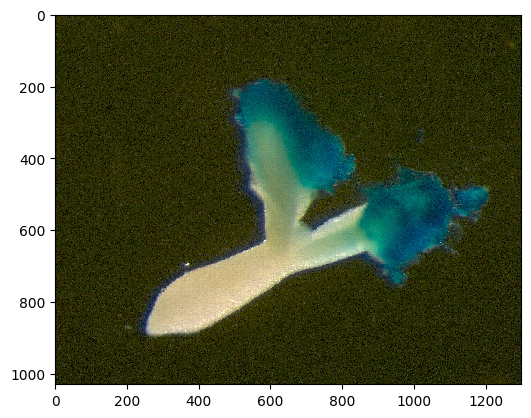

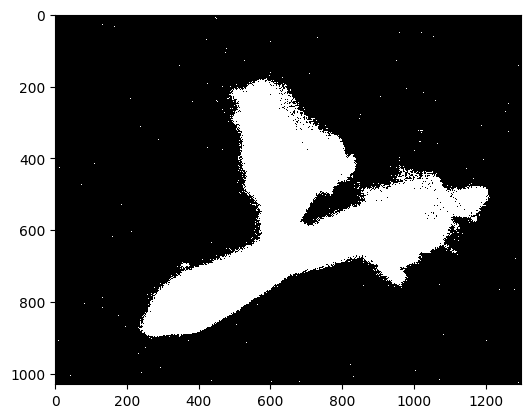

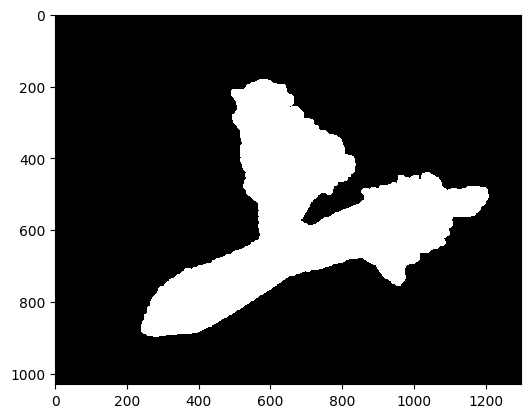

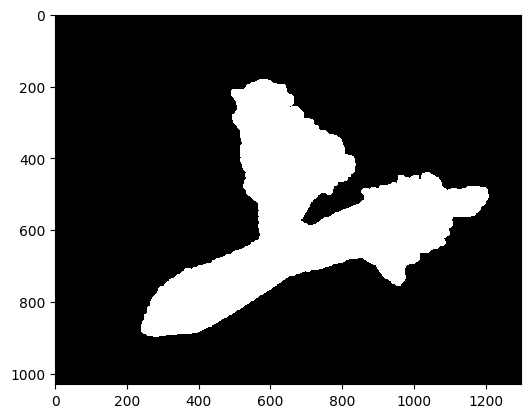

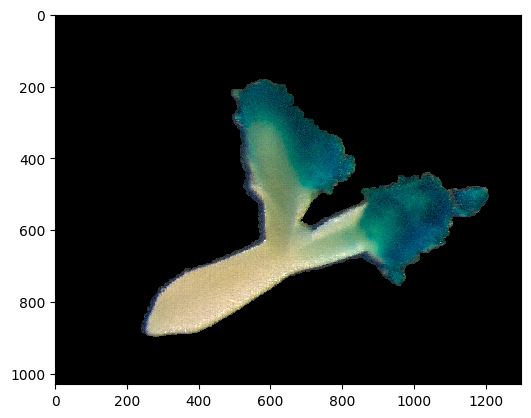

In [70]:
img = dip.ImageRead(image_paths[0])
img.Show()

# Threshold on the blue channel
img_bin = dip.OtsuThreshold(img(2))
img_bin.Show()

# Apply closing to fill gaps in embryo
img_bin = dip.Closing(img_bin, dip.SE((3,3), "elliptic"))
# Apply opening to remove small artifacts outside embtyo and define embryo edges
img_bin = dip.Opening(img_bin, dip.SE((20,20), "elliptic"))
img_bin.Show()
# Remove edge object
img_bin = dip.EdgeObjectsRemove(img_bin)
img_bin.Show()

# Label remaining objects
img_lbl = dip.Label(img_bin)
# Measure object sizes
m = dip.MeasurementTool.Measure(img_lbl, img, ["Size"])
# Derive largest object
largest_lbl = np.argmax(m["Size"]) + 1

embryo_mask = img_lbl == largest_lbl

img[~embryo_mask] = 0
img.Show()


